<a href="https://colab.research.google.com/github/JibrilTheUltimateFlugel/TensorflowTest/blob/main/TensorflowCNNresnetmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.python.keras.api._v2.keras import layers, Sequential, regularizers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow import keras
import tensorflow.keras.preprocessing.image as image

In [16]:
np.set_printoptions(threshold=np.inf)#Console output all values
#Preprocessing
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [3]:
#Data set segmentation
x_valid,x_train=x_train[:3000],x_train[3000:]
y_valid,y_train=y_train[:3000],y_train[3000:]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


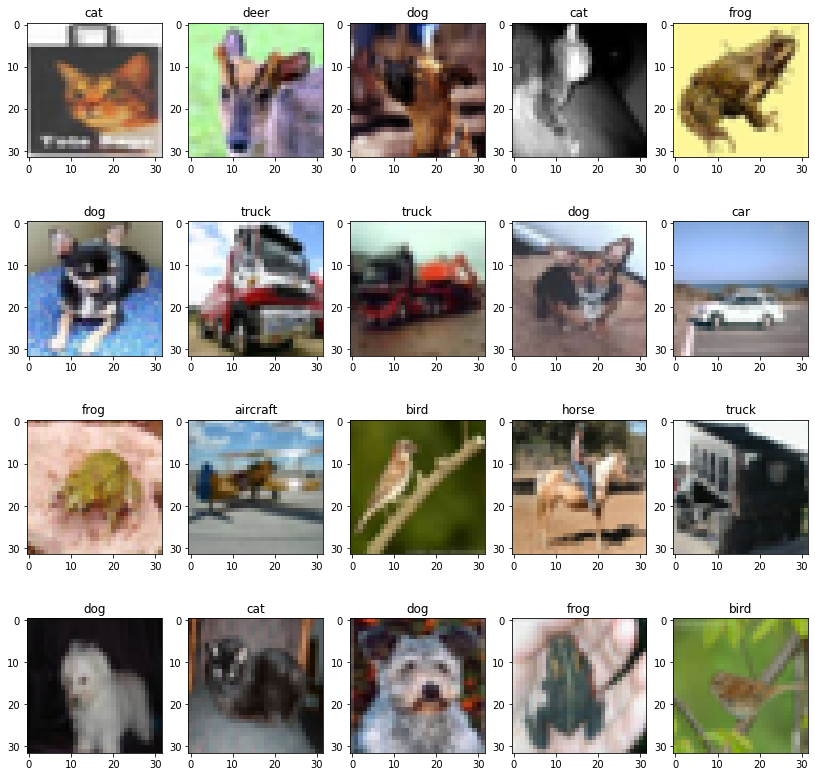

In [4]:
#Data Display
labels = ['aircraft','car','bird','cat','deer','dog','frog','horse','ferry','truck']
plt.figure(figsize=(14,14)) 
#Display the images, and display the category on the image
for i in range(20):   
    plt.subplot(4,5,i+1)
    plt.grid(False)
    plt.imshow(x_train[i,:,:,],cmap=plt.cm.binary)
    plt.rcParams['font.sans-serif']=['SimHei']
    t = labels[y_train[i][0]]
    plt.title(t) 
plt.show()

In [6]:
class ResnetBlock(Model):

    def __init__(self, filters, strides=1, residual_path=False):
        super(ResnetBlock, self).__init__()
        self.filters = filters
        self.strides = strides
        self.residual_path = residual_path

        self.c1 = Conv2D(filters, (3, 3), strides=strides, padding='same',
                         kernel_regularizer=regularizers.l2(5e-5), use_bias=False, kernel_initializer='glorot_normal')
        self.b1 = BatchNormalization()
        self.a1 = Activation('relu')

        self.c2 = Conv2D(filters, (3, 3), strides=1, padding='same', 
                          kernel_regularizer=regularizers.l2(5e-5), use_bias=False, kernel_initializer='glorot_normal')
        self.b2 = BatchNormalization()

        # When residual_path is True, the input is down-sampled, that is, the 1x1 convolution kernel is used for convolution operation to ensure that x can have the same dimension as F(x)
        if residual_path:
            self.down_c1 = Conv2D(filters, (1, 1), strides=strides, padding='same', 
                                  kernel_regularizer=regularizers.l2(5e-5), use_bias=False, kernel_initializer='glorot_normal')
            self.down_b1 = BatchNormalization()
        
        self.a2 = Activation('relu')

        def call(self, inputs):
          residual = inputs  # residual is equal to the input value itself, residual=x
          # Pass the input through the convolution, BN layer, and activation layer to calculate F(x)
          x = self.c1(inputs)
          x = self.b1(x)
          x = self.a1(x)

          x = self.c2(x)
          y = self.b2(x)

          if self.residual_path:
              residual = self.down_c1(inputs)
              residual = self.down_b1(residual)

          out = self.a2(y + residual)  # The final output is the sum of the two parts, namely F(x)+x and then the activation function
          return out

In [8]:
class ResNet18(Model):

    def __init__(self, block_list, initial_filters=64):  # block_list means that each block has several convolutional layers
        super(ResNet18, self).__init__()
        self.num_blocks = len(block_list)
        self.block_list = block_list
        self.out_filters = initial_filters
        self.c1 = Conv2D(self.out_filters, (3, 3), strides=1, padding='same', use_bias=False)
        self.b1 = BatchNormalization()
        self.a1 = Activation('relu')
        self.blocks = tf.keras.models.Sequential()
        # Construct ResNet network structure
        for block_id in range(len(block_list)):
            for layer_id in range(block_list[block_id]):
                if block_id != 0 and layer_id == 0:  # Downsample the input of each block except the first block
                    block = ResnetBlock(self.out_filters, strides=2, residual_path=True)
                else:
                    block = ResnetBlock(self.out_filters, residual_path=False)
                self.blocks.add(block)
            self.out_filters *= 2  # The number of convolution kernels in the next block is twice that of the previous block
        self.p1 = tf.keras.layers.GlobalAveragePooling2D()
        self.f1 = tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())

        def call(self, inputs):
          x = self.c1(inputs)
          x = self.b1(x)
          x = self.a1(x)
          x = self.blocks(x)
          x = self.p1(x)
          y = self.f1(x)
          return y

In [13]:
#Model training
def model_train(x_train,y_train,x_valid,y_valid):
    
    model = ResNet18([2, 2, 2, 2])
    save_path = 'resnet18.h5'
    
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['sparse_categorical_accuracy'])
    
    checkpoint_save_path = "ResNet18.ckpt"
    if os.path.exists(checkpoint_save_path + '.index'):
        print('-------------load the model-----------------')
        model.load_weights(checkpoint_save_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)
    
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./model',histogram_freq =1,write_grads=True)
    history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_valid, y_valid), validation_freq=1,
                   callbacks=[tensorboard])
    #history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_valid, y_valid), validation_freq=1,
                #   callbacks=[cp_callback])
    model.summary()
    
    #Weight preservation
    file = open('./weights.txt', 'w')
    for v in model.trainable_variables:
        file.write(str(v.name) + '\n')
        file.write(str(v.shape) + '\n')
        file.write(str(v.numpy()) + '\n')
    file.close()
   
    #Model save
    #model_path ='resnet18.h5'
    #tf.saved_model.save(model,model_path)
    #Model Diagram Save
    #plot_model(model, to_file='resnet18_model.jpg',show_shapes=True)
    return history,model

In [10]:
#data visualization
def figshow(history):
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.subplots(figsize=(8,6))
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    plt.subplots(figsize=(8,6))
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [11]:
#Test Set Test
def data_test(x_test,y_test,model):
    loss, acc = model.evaluate(x_test, y_test)
    top1_acc = acc
    #print("test_accuracy:{:5.2f}%".format(100 * acc))
    y_pred = model.predict(x_test)
    k_b = tf.math.top_k(y_pred,2).indices
    idx=0
    acc=0.0
    for i in k_b:
        if y_test[idx] in i.numpy():
            acc=acc+1
        idx=idx+1
    top2_acc=acc/y_test.shape[0] 
    print('Best accuracy rate: {0}\nSecond best accuracy rate: {1}'.format(top1_acc,top2_acc))
    return top1_acc,top2_acc

In [17]:
if __name__ == '__main__':
    #training
    history, model= model_train(x_train,y_train,x_test,y_test)
    figshow(history)
    #test
    data_test(x_test,y_test,model)

Epoch 1/10


NotImplementedError: ignored

Epoch 1/10
1469/1469 [==============================] - 49s 31ms/step - loss: 1.5977 - sparse_categorical_accuracy: 0.5517 - val_loss: 1.3396 - val_sparse_categorical_accuracy: 0.6324
Epoch 2/10
1469/1469 [==============================] - 44s 30ms/step - loss: 1.0911 - sparse_categorical_accuracy: 0.7185 - val_loss: 1.1791 - val_sparse_categorical_accuracy: 0.6842
Epoch 3/10
1469/1469 [==============================] - 41s 28ms/step - loss: 0.9722 - sparse_categorical_accuracy: 0.7701 - val_loss: 1.3676 - val_sparse_categorical_accuracy: 0.6409
Epoch 4/10
1469/1469 [==============================] - 44s 30ms/step - loss: 0.9130 - sparse_categorical_accuracy: 0.8000 - val_loss: 1.0972 - val_sparse_categorical_accuracy: 0.7449
Epoch 5/10
1469/1469 [==============================] - 42s 28ms/step - loss: 0.8622 - sparse_categorical_accuracy: 0.8243 - val_loss: 1.0115 - val_sparse_categorical_accuracy: 0.7766
Epoch 6/10
1469/1469 [==============================] - 42s 28ms/step - loss: 0.

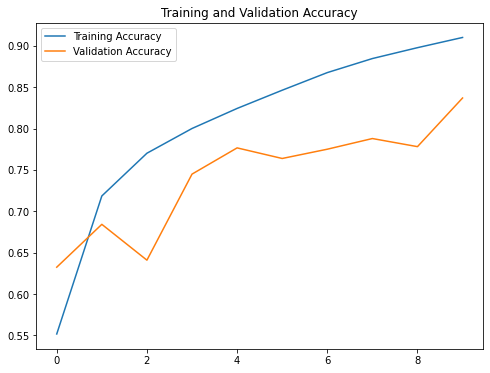

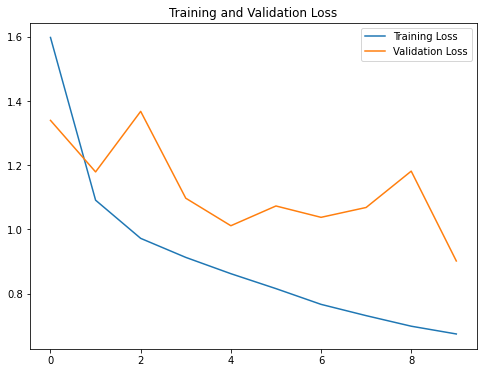

313/313 [==============================] - 3s 9ms/step - loss: 0.9018 - sparse_categorical_accuracy: 0.8369
Best accuracy rate: 0.836899995803833
Second best accuracy rate: 0.9338


In [3]:
#Combine everything together into one set
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.python.keras.api._v2.keras import layers, Sequential, regularizers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow import keras
import tensorflow.keras.preprocessing.image as image

np.set_printoptions(threshold=np.inf)#Console output all values
#Preprocessing
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

#Data set segmentation
x_valid,x_train=x_train[:3000],x_train[3000:]
y_valid,y_train=y_train[:3000],y_train[3000:]

#Data Display
labels = ['aircraft','car','bird','cat','deer','dog','frog','horse','ferry','truck']

class ResnetBlock(Model):

    def __init__(self, filters, strides=1, residual_path=False):
        super(ResnetBlock, self).__init__()
        self.filters = filters
        self.strides = strides
        self.residual_path = residual_path

        self.c1 = Conv2D(filters, (3, 3), strides=strides, padding='same',
                         kernel_regularizer=regularizers.l2(5e-5), use_bias=False, kernel_initializer='glorot_normal')
        self.b1 = BatchNormalization()
        self.a1 = Activation('relu')

        self.c2 = Conv2D(filters, (3, 3), strides=1, padding='same', 
                          kernel_regularizer=regularizers.l2(5e-5), use_bias=False, kernel_initializer='glorot_normal')
        self.b2 = BatchNormalization()

        # When residual_path is True, the input is down-sampled, that is, the 1x1 convolution kernel is used for convolution operation to ensure that x can have the same dimension as F(x)
        if residual_path:
            self.down_c1 = Conv2D(filters, (1, 1), strides=strides, padding='same', 
                                  kernel_regularizer=regularizers.l2(5e-5), use_bias=False, kernel_initializer='glorot_normal')
            self.down_b1 = BatchNormalization()
        
        self.a2 = Activation('relu')

    def call(self, inputs):
        residual = inputs  # residual is equal to the input value itself, residual=x
        # Pass the input through the convolution, BN layer, and activation layer to calculate F(x)
        x = self.c1(inputs)
        x = self.b1(x)
        x = self.a1(x)

        x = self.c2(x)
        y = self.b2(x)

        if self.residual_path:
            residual = self.down_c1(inputs)
            residual = self.down_b1(residual)

        out = self.a2(y + residual)  # The final output is the sum of the two parts, namely F(x)+x and then the activation function
        return out

class ResNet18(Model):

    def __init__(self, block_list, initial_filters=64):  # block_list means that each block has several convolutional layers
        super(ResNet18, self).__init__()
        self.num_blocks = len(block_list)
        self.block_list = block_list
        self.out_filters = initial_filters
        self.c1 = Conv2D(self.out_filters, (3, 3), strides=1, padding='same', use_bias=False)
        self.b1 = BatchNormalization()
        self.a1 = Activation('relu')
        self.blocks = tf.keras.models.Sequential()
        # Construct ResNet network structure
        for block_id in range(len(block_list)):
            for layer_id in range(block_list[block_id]):
                if block_id != 0 and layer_id == 0:  # Downsample the input of each block except the first block
                    block = ResnetBlock(self.out_filters, strides=2, residual_path=True)
                else:
                    block = ResnetBlock(self.out_filters, residual_path=False)
                self.blocks.add(block)
            self.out_filters *= 2  # The number of convolution kernels in the next block is twice that of the previous block
        self.p1 = tf.keras.layers.GlobalAveragePooling2D()
        self.f1 = tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())

    def call(self, inputs):
        x = self.c1(inputs)
        x = self.b1(x)
        x = self.a1(x)
        x = self.blocks(x)
        x = self.p1(x)
        y = self.f1(x)
        return y

#Model training
def model_train(x_train,y_train,x_valid,y_valid):
    
    model = ResNet18([2, 2, 2, 2])
    save_path = 'resnet18.h5'
    
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['sparse_categorical_accuracy'])
    
    checkpoint_save_path = "ResNet18.ckpt"
    if os.path.exists(checkpoint_save_path + '.index'):
        print('-------------load the model-----------------')
        model.load_weights(checkpoint_save_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)
    
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./model',histogram_freq =1,write_grads=True)
    history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_valid, y_valid), validation_freq=1,
                   callbacks=[tensorboard])
    #history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_valid, y_valid), validation_freq=1,
                #   callbacks=[cp_callback])
    model.summary()
    
    #Weight preservation
    file = open('./weights.txt', 'w')
    for v in model.trainable_variables:
        file.write(str(v.name) + '\n')
        file.write(str(v.shape) + '\n')
        file.write(str(v.numpy()) + '\n')
    file.close()
   
    #Model save
    #model_path ='resnet18.h5'
    #tf.saved_model.save(model,model_path)
    #Model Diagram Save
    #plot_model(model, to_file='resnet18_model.jpg',show_shapes=True)
    return history,model

#data visualization
def figshow(history):
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.subplots(figsize=(8,6))
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    plt.subplots(figsize=(8,6))
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

#Test Set Test
def data_test(x_test,y_test,model):
    loss, acc = model.evaluate(x_test, y_test)
    top1_acc = acc
    #print("test_accuracy:{:5.2f}%".format(100 * acc))
    y_pred = model.predict(x_test)
    k_b = tf.math.top_k(y_pred,2).indices
    idx=0
    acc=0.0
    for i in k_b:
        if y_test[idx] in i.numpy():
            acc=acc+1
        idx=idx+1
    top2_acc=acc/y_test.shape[0] 
    print('Best accuracy rate: {0}\nSecond best accuracy rate: {1}'.format(top1_acc,top2_acc))
    return top1_acc,top2_acc

if __name__ == '__main__':
    #training
    history, model= model_train(x_train,y_train,x_test,y_test)
    figshow(history)
    #test
    data_test(x_test,y_test,model)